In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_f/virtual_samples_RationalQuadratic.xlsx")

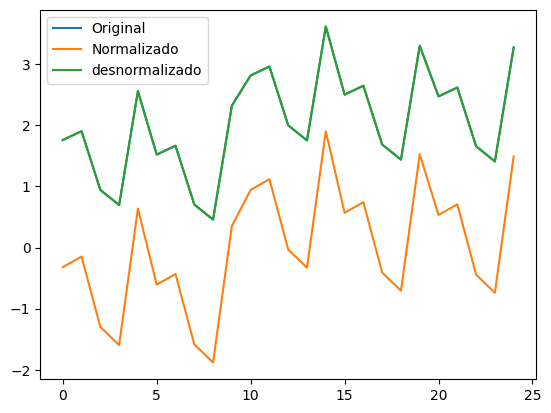

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [ ]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:37:15.987074: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:37:16.010966: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:37:16.173576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753137436.340578 1772047 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753137436.348974 1772047 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753137436.430567 1772047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [ ]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[12], regularizer=0.2, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_4,0.999065,-0.642862,0.997542,0.903697,0.132281,242.946478,0.937333,0.115650,0.183925,0.363704,0.996012,0.369432,102.045658,208.590634
model_1_0_2,0.998218,-0.647846,0.995959,0.689999,0.252154,243.683552,1.541101,0.372278,0.121826,0.502149,0.992398,0.510058,100.755431,207.300408
model_1_0_3,0.998269,-0.658296,0.996054,0.703428,0.245029,245.228916,1.504693,0.356151,0.118634,0.495004,0.992613,0.502800,100.812760,207.357736
model_1_0_0,0.964519,-0.742134,0.976457,-4.944145,5.021509,257.626771,8.978538,7.138289,1.019720,2.240872,0.848615,2.276164,94.772539,201.317515
model_1_0_1,0.992098,-0.792091,0.990102,-0.344402,1.118374,265.014526,3.774874,1.614484,0.317672,1.057532,0.966284,1.074187,97.776248,204.321225


DataFrame salvo em ./content/results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  27
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  28
3/3 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_5,0.999999,-0.550575,0.998460,0.999998,0.000131,229.299131,0.587270,0.000387,0.005220,0.011461,0.999996,0.011641,115.875275,222.420251
model_1_1_6,0.999999,-0.550580,0.998460,0.999998,0.000131,229.299855,0.587259,0.000386,0.005220,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_1_7,0.999999,-0.550580,0.998460,0.999998,0.000131,229.299855,0.587259,0.000386,0.005220,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_1_8,0.999999,-0.550580,0.998460,0.999998,0.000131,229.299855,0.587259,0.000386,0.005220,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_1_9,0.999999,-0.550580,0.998460,0.999998,0.000131,229.299855,0.587259,0.000386,0.005220,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_1_4,0.999999,-0.556340,0.998437,0.999998,0.000132,230.151556,0.596137,0.000385,0.005226,0.011474,0.999996,0.011655,115.870548,222.415524
model_1_1_3,0.999999,-0.563611,0.998410,0.999998,0.000159,231.226897,0.606456,0.000436,0.005461,0.012590,0.999995,0.012789,115.499298,222.044274
model_1_1_2,0.999987,-0.589905,0.998216,0.999981,0.001784,235.115271,0.680386,0.003742,0.009825,0.042240,0.999946,0.042906,110.657515,217.202491
model_1_1_1,0.999953,-0.604033,0.998081,0.999942,0.006621,237.204391,0.731984,0.011803,0.024316,0.081370,0.999800,0.082651,108.035011,214.579987
model_1_1_0,0.999367,-0.641131,0.997643,0.999497,0.089567,242.690440,0.898809,0.101613,0.147246,0.299277,0.997300,0.303991,102.825540,209.370517


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_0,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_1,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_2,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_3,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_4,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_5,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_6,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_7,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_8,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_2_9,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000064,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_0,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_1,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_2,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_3,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_4,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_5,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_6,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_7,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_8,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_3_9,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000116,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_1,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_2,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_3,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_4,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_5,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_6,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_7,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_8,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_4_9,0.999999,-0.55058,0.99846,0.999997,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_1,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_2,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_3,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_4,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_5,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_6,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_7,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_8,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_5_9,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000204,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_1,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_2,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_3,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_4,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_5,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_6,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_7,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_8,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_6_9,0.999999,-0.55058,0.99846,0.999783,0.000131,229.299855,0.587259,0.000145,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_1,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_2,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_3,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_4,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_5,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_6,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_7,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_8,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_7_9,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.0001,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_1,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_2,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_3,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_4,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_5,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_6,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_7,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_8,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_8_9,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000062,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_1,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_2,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_3,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_4,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_5,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_6,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_7,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_8,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_9_9,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000181,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_1,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_2,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_3,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_4,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_5,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_6,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_7,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_8,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_10_9,0.999999,-0.55058,0.99846,0.999998,0.000131,229.299855,0.587259,0.000124,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_1,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_2,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_3,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_4,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_5,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_6,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_7,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_8,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_11_9,0.999999,-0.55058,0.99846,0.999985,0.000131,229.299855,0.587259,0.00025,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_1,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_2,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_3,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_4,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_5,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_6,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_7,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_8,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_12_9,0.999999,-0.55058,0.99846,0.999986,0.000131,229.299855,0.587259,0.00014,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_1,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_2,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_3,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_4,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_5,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_6,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_7,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_8,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_13_9,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.00018,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_1,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_2,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_3,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_4,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_5,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_6,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_7,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_8,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_14_9,0.999999,-0.55058,0.99846,0.999999,0.000131,229.299855,0.587259,0.000094,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_1,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_2,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_3,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_4,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_5,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_6,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_7,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_8,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_15_9,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000054,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_1,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_2,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_3,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_4,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_5,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_6,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_7,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_8,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_16_9,0.999999,-0.55058,0.99846,1.0,0.000131,229.299855,0.587259,0.000119,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_1,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_2,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_3,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_4,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_5,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_6,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_7,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_8,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001
model_1_17_9,0.999999,-0.55058,0.99846,0.999988,0.000131,229.299855,0.587259,0.000126,0.00522,0.011459,0.999996,0.011639,115.876024,222.421001


DataFrame salvo em ./content/results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
